Tzvi Aviv
November 11th, 2021
Loblaw/Vector PETS workshop

This notebook will adopt VFL for a pharmacy providing data into a hospital to predict hospital mortality in the ICU
a mockup scenario from mimic3 dataset. Data prep is in another notebook.

# ***Introduction to Vertical Federated Learning*** 

## **Background**

### Vertically Partitioned Data

Often data exists in silos. This can be the case within an organization or among multiple organizations. In each case, the feature of a unique sample is distributed among multple datasets held by different parties. Exchanging data allows the parties to leverage a more complete feature set, thus enhancing the performance of the system. However, privacy restrictions often prevent the parties from doing so. 



### Vertical Federated Learning

Inspired by this limitation, [Vertical Federated Learning](https://blog.openmined.org/federated-learning-types/) (VFL) was introduced. VFL involves training a joint model on data that has features partitioned accross multiple datasets without explictly exchanging the features among parties.
<p align="center">
<img width="433" alt="Screen Shot 2021-09-28 at 5 41 20 PM" src="https://user-images.githubusercontent.com/34798787/135169716-27e0e6a1-1d45-421d-882a-27241805b401.png">
</p>

### Use Case

see data prep in another notebook

### Tools
In order to perform VFL, data and computation need to be distributed amongst the remote machine(s) of each party. However, deep learning frameworks like PyTorch and TensorFlow do not offer this functionality of the box. Fortunately [PySyft](https://blog.openmined.org/tag/pysyft/), a Python library for secure and private Deep Learning, extends both PyTorch and Keras to provide tools to perform VFL.

## **Demo Overview**
Prepared by Vector institute for Credit evaluation and adopted to healthcare by Loblaw HDPS team 

In the following demo, VFL is used to train a joint model between a Pharmacy and the Hospital to predict hospital mortality using PyTorch and PySyft. 
During this process, only abstract representations of features are shared thus eliminating the need to explictly exchange features. When coupled with differential privacy, VFL provides a robust solution to privacy preserving AI. 

The follwing demo contains three sections: 
1. **Data Preparation**
    *  Define Vertical Dataloader 
    *  Find correspondences with Private Set Intersection

2. **Model Preparation**
    * Define Sub Model 
    * Define Split Neural Network

3. **Training and Validation**
    * Define train and validation loop
    * Interpret results

# ***Demo*** 

## **Environment Configuration and Package Imports**

In [1]:
import os 
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data._utils.collate import default_collate

from sklearn.metrics import roc_auc_score

import syft as sy
from uuid import UUID
from uuid import uuid4

hook = sy.TorchHook(torch) 

In [2]:
from src.psi.util import Client, Server
from src.utils import add_ids
from src.utils.data_utils import id_collate_fn

In [3]:
from sklearn.preprocessing import MinMaxScaler

### Define Dataset Class

In [4]:
class VerticalDataset(Dataset):
    """Dataset for Vertical Federated Learning"""

    def __init__(self, ids, data, labels=None):
        """
        Args:
            ids (Numpy Array) : Numpy Array with UUIDS
            data (Numpy Array) : Numpy Array with Features
            targets (Numpy Array) : Numpy Array with Labels. None if not available. 
        """
        self.ids = ids
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        """Return record single record"""
        feature = self.data[index].astype(np.float32)

        if self.labels is None:
            label  = None
        else:
            label = int(self.labels[index]) if self.labels is not None else None

        id = self.ids[index]

        # Return a tuple of non-None elements
        return (*filter(lambda x: x is not None, (feature, label, id)),)
    
    def get_ids(self):
        """Return a list of the ids of this dataset."""
        return [str(id_) for id_ in self.ids]
    
    def sort_by_ids(self):
        """
        Sort the dataset by IDs in ascending order
        """
        ids = self.get_ids()
        sorted_idxs = np.argsort(ids)


        self.data = self.data[sorted_idxs]

        if self.labels is not None:
            self.labels = self.labels[sorted_idxs]

        self.ids = self.ids[sorted_idxs]

### Load Data


In [5]:
!pwd

/ssd003/home/taviv/mimic3-benchmarks/VFL_PySyft_SplitNN


In [6]:
!ls ..

data				   mimic3benchmark     test_data.npy
data_ta				   mimic3models        test_lbl.npy
feature_table.csv		   pharmacy_test.csv   train_data.npy
Hospital_mortality_episodes.ipynb  pharmacy_train.csv  train_lbl.npy
hospital_test.csv		   README.md	       val_data.npy
hospital_train.csv		   requirements.txt    val_lbl.npy
LICENSE				   statistics.md       VFL_PySyft_SplitNN


In [19]:
# Load pharmacy
data_dir = "/ssd003/home/taviv/mimic3-benchmarks"
PH_DATA_PATH = f"{data_dir}/pharmacy_train.csv"
ph_df = pd.read_csv(PH_DATA_PATH)
ph_df.rename(columns={"Unnamed: 0":"SUBJ_ID"}, inplace=True)

In [8]:
#fill nan with zeros
#ph_df = ph_df.fillna(0)

In [9]:
#scaling
#ph_df=pd.DataFrame(MinMaxScaler().fit_transform(ph_df))

In [20]:
ph_df.head()

,SUBJ_ID,42,43,44,45,46,47,48,49,50,...,663,664,665,666,667,668,669,670,671,label
0,97271,39.0,69.0,52.246376,6.477175,0.542092,69.0,39.0,53.0,48.444443,...,0.0,0.0,1.0,114.000000,114.000000,114.000000,0.0,0.0,1.0,0
1,29742,41.0,120.0,63.802818,13.510162,1.704696,71.0,53.0,99.0,68.400002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,3362,36.0,68.0,48.981480,7.778152,0.697511,54.0,54.0,68.0,63.000000,...,0.0,0.0,1.0,118.599998,118.599998,118.599998,0.0,0.0,1.0,0
3,5407,37.0,82.0,51.491802,7.723974,0.973102,61.0,42.0,58.0,49.500000,...,0.0,0.0,1.0,90.400002,90.400002,90.400002,0.0,0.0,1.0,0
4,19220,37.0,89.0,57.854168,9.302754,0.307232,48.0,37.0,62.0,50.200001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [21]:
ph_df.label.value_counts()

0    9998
1    1567
Name: label, dtype: int64

In [22]:
#Load Hospital Data
HO_DATA_PATH = f"{data_dir}/hospital_train.csv"
ho_df = pd.read_csv(HO_DATA_PATH)
ho_df.rename(columns={"Unnamed: 0":"SUBJ_ID"}, inplace=True)

In [23]:
# Carve out validation set
assert ho_df.shape[0] == ph_df.shape[0]
val_size = 2000
val_ind = np.random.choice(range(ho_df.shape[0]), val_size, replace=False)
ho_df_val = ho_df.iloc[val_ind]
ph_df_val = ph_df.iloc[val_ind]
#correct a mistake in the vector demo below
ph_df.drop(val_ind, axis = 0,inplace=True)
ho_df.drop(val_ind, axis = 0,inplace=True)

In [24]:
# Get UID Column
uuids = np.array([uuid4() for _ in range(len(ho_df))])
uuids_val = np.array([uuid4() for _ in range(len(ho_df_val))])

### Visualize Data

In [25]:
## Home Credit Training Set
print(f"Training \tPharmacy: {str(ph_df.shape)} Hospital: {str(ho_df.shape)}")
print(f"Validation: \tPharmacy: {str(ph_df_val.shape)} Hospital: {str(ho_df_val.shape)}")

Training 	Pharmacy: (9565, 212) Hospital: (9565, 422)
Validation: 	Pharmacy: (2000, 212) Hospital: (2000, 422)


### Define Dataloader Classes 


In [26]:
class SinglePartitionDataLoader(DataLoader):
    """DataLoader for a single vertically-partitioned dataset"""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.collate_fn = id_collate_fn

class VerticalDataLoader:
    """Dataloader which batches data from a complete
    set of vertically-partitioned datasets
    i.e. the images dataset AND the labels dataset
    """

    def __init__(self, ho_data, ph_data, *args, **kwargs):

        self.dataloader1 = SinglePartitionDataLoader(
            ho_data, *args, **kwargs
        )
        self.dataloader2 = SinglePartitionDataLoader(
            ph_data, *args, **kwargs
        )

    def __iter__(self):
        """
        Zip Dataloaders 
        """
        return zip(self.dataloader1, self.dataloader2)

    def __len__(self):
        """
        Return length of dataset
        """
        return (len(self.dataloader1) + len(self.dataloader2)) // 2

    def drop_non_intersecting(self, intersection):
        """Remove elements and ids in the datasets that are not in the intersection."""
        self.dataloader1.dataset.data = self.dataloader1.dataset.data[intersection]
        self.dataloader1.dataset.ids = self.dataloader1.dataset.ids[intersection]

        self.dataloader1.dataset.labels = self.dataloader1.dataset.labels[intersection]
        self.dataloader2.dataset.ids = self.dataloader2.dataset.ids[intersection]

    def sort_by_ids(self) -> None:
        """
        Sort each dataset by ids
        """
        self.dataloader1.dataset.sort_by_ids()
        self.dataloader2.dataset.sort_by_ids()

## Initialize Datasets 

In [27]:
# Hospital Dataset

#Training
ho_labels = np.array(ho_df.pop("label"))
ho_data = ho_df.iloc[:,1:] #remove the subject_id
#fill na and scale
ho_data = ho_data.fillna(0)
ho_data = pd.DataFrame(MinMaxScaler().fit_transform(ho_data))
ho_data = np.array(ho_data)

print("train", uuids.shape, ho_data.shape, ho_labels.shape)
ho_dim = ho_data.shape[1]
ho_dataset = VerticalDataset(ids=uuids, data=ho_data, labels=ho_labels)

#Validation
ho_labels_val = np.array(ho_df_val.pop("label"))
ho_data_val = ho_df_val.iloc[:,1:] #remove the subject_id
#fill na and scale
ho_data_val = ho_data_val.fillna(0)
ho_data_val = pd.DataFrame(MinMaxScaler().fit_transform(ho_data_val))
ho_data_val = np.array(ho_data_val)

print("val", uuids_val.shape, ho_data_val.shape, ho_labels_val.shape)
ho_dataset_val = VerticalDataset(ids=uuids_val, data=ho_data_val, labels=ho_labels_val)

train (9565,) (9565, 420) (9565,)
val (2000,) (2000, 420) (2000,)


In [58]:
ho_data.dtype

dtype('float64')

In [55]:
ho_labels.dtype

dtype('int64')

In [14]:
#ho_feat_dim=420

In [28]:
# Pharmacy Dataset

#Training
ph_data = ph_df.iloc[:,1:-1]
#fill na and scale
ph_data = ph_data.fillna(0)
ph_data = pd.DataFrame(MinMaxScaler().fit_transform(ph_data))
ph_data = np.array(ph_data)

#print(ph_data.shape)
ph_dim = ph_data.shape[1]
ph_feat_dim = 210
ph_dataset = VerticalDataset(ids=uuids, data=ph_data, labels=None)


#Validation
#fill na and scale
ph_data_val = ph_df_val.iloc[:,1:-1]
ph_data_val = ph_data_val.fillna(0)
ph_data_val = pd.DataFrame(MinMaxScaler().fit_transform(ph_data_val))
ph_data_val = np.array(ph_data_val)
ph_dataset_val = VerticalDataset(ids=uuids_val, data=ph_data_val, labels=None)

In [51]:
print("train", uuids.shape, ph_data.shape, ho_labels.shape)

train (9565,) (9565, 210) (9565,)


## Initialize Dataloader

In [29]:
## Initialize Train Dataloader 
dataloader = VerticalDataLoader(ho_dataset, ph_dataset, batch_size=2048)

# Compute private set intersection
client_items = dataloader.dataloader1.dataset.get_ids()
server_items = dataloader.dataloader2.dataset.get_ids()
 
client = Client(client_items)
server = Server(server_items)

setup, response = server.process_request(client.request, len(client_items))
intersection = client.compute_intersection(setup, response)

# Order data
dataloader.drop_non_intersecting(intersection)
dataloader.sort_by_ids()

In [30]:
## Initialize Train Dataloader 
val_dataloader = VerticalDataLoader(ho_dataset_val, ph_dataset_val, batch_size=2048)

# Compute private set intersection
val_client_items = val_dataloader.dataloader1.dataset.get_ids()
val_server_items = val_dataloader.dataloader2.dataset.get_ids()

val_client = Client(val_client_items)
val_server = Server(val_server_items)

val_setup, val_response = val_server.process_request(val_client.request, len(val_client_items))
val_intersection = val_client.compute_intersection(val_setup, val_response)

# Order data
val_dataloader.drop_non_intersecting(val_intersection)
val_dataloader.sort_by_ids()

## **Model Preparation** by Vector for home credit
In the model preparation stage, both Home Credit and the Credit Bureau initialize a model. Subsequently, a [Split Neural Network](https://arxiv.org/pdf/1810.06060.pdf) (SplitNN) is defined with the Home Credit and Credit Bureau models as submodules. SplitNN orchestrates the flow of data and gradients within and accross submodules that are potentially on different machines. Data shared accross modules is in the form of representations to avoid explicitly exchanging features accross organizations. 
<p align="center">
<img width="400" alt="Screen Shot 2021-09-29 at 1 10 17 PM" src="https://user-images.githubusercontent.com/34798787/135316709-81bdb0ae-591c-4a67-8275-23f10c7b2610.png">
</p>

In this demo, the SplitNN is defined as follows: 
<p align="center">
<img width="500" alt="Screen Shot 2021-09-29 at 1 19 14 PM" src="https://user-images.githubusercontent.com/34798787/135317891-49eb6157-ad14-4ec3-ae85-d5341e23b7c6.png">
</p>

In [31]:
ho_dim

420

In [32]:
ph_dim

210

In [43]:
ho_feat_dim

NameError: name 'ho_feat_dim' is not defined

In [44]:
ph_feat_dim

210

### Model Definitions

In [35]:
class HOModel(torch.nn.Module):
    """ 
    Model for Hospital
    
    Attributes
    ----------
    ph_dim: 
        Dimensionality of Pharmacy Data
    Methods
    -------
    forward(x):
        Performs a forward pass through the Credit Bureau Model
    """
    def __init__(self, ho_dim, ph_dim): 
        super(HOModel, self).__init__()
        self.fused_input_dim = ho_dim + ph_dim
        self.layers = nn.Sequential(
            nn.Linear(self.fused_input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    
    def forward(self, ho_feat, ph_feat):
        feat = torch.cat([ho_feat, ph_feat], dim=1)
        pred = self.layers(feat)
        return pred

In [36]:
class PHModel(torch.nn.Module):
    """ 
    Model for Pharmacy
    
    Attributes
    ----------
    ph_dim: 
        Dimensionality of pharmacy Data
    Methods
    -------
    forward(x):
        Performs a forward pass through the pharmacy Model
    """
    
    def __init__(self, ph_dim): 
        super(PHModel, self).__init__()
        self.ph_dim = ph_dim
        self.layers = torch.nn.Sequential(
            nn.Linear(self.ph_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.Sigmoid()
        )
    
    def forward(self, ph_feat):
        pred = self.layers(ph_feat)
        return pred

In [37]:
class SplitNN:
    """
    A class representing SplitNN

    Attributes
    ----------
    ho_model:  
        Hospital Neural Network Module

    ph_model:   
        Pharmacy Neural Network Module

    ho_opt:  
        Optimizer for the Hospital Neural Network Module

    ph_model:   
        Optimizer for the Pharmacy Neural Network Module

    data: 
        A list storing intermediate computations at each index

    remote_tensors: 
        A list storing intermediate computations at each index (Computation from each model detached from global computation graph)

    Methods
    -------
    forward(x):
        Performs a forward pass through the SplitNN

    backward(): 
        Performs a backward pass through the SplitNN

    zero_grads():
        Zeros the gradients of all networks in SplitNN

    step():
        Updates the parameters of all networks in SplitNN
    """


    def __init__(self, ho_model, ph_model, ho_opt, ph_opt):
        self.ho_model = ho_model
        self.ph_model = ph_model
        self.ho_opt = ho_opt
        self.ph_opt = ph_opt
        self.data = []
        self.remote_tensors = []

    def forward(self, ho_x, ph_x):
        """
        Parameters
        ----------
        x:  
            Input Sample 
        """

        data = []
        remote_tensors = []

        # Forward pass through first model
        data.append(self.ph_model(ph_x))

        # if location of data is the same as location of the subsequent model
        if data[-1].location == self.ho_model.location:
            # store computation in remote tensor array 
            # Gradients will be only computed backward upto the point of detachment
            remote_tensors.append(data[-1].detach().requires_grad_())
        else:
            # else move data to location of subsequent model and store computation in remote tensor array 
            # Gradients will be only computed backward upto the point of detachment
            remote_tensors.append(
                data[-1].detach().move(self.ho_model.location).requires_grad_()
            )

        # Get and return final output of model
        data.append(self.ho_model(ho_x, remote_tensors[-1]))

        self.data = data 
        self.remote_tensors = remote_tensors
        return data[-1]

    def backward(self):
        # if location of data is the same as detatched data 
        if self.remote_tensors[0].location == self.data[0].location:
            # Store gradients from remote_tensor 
            grads = self.remote_tensors[0].grad.copy()
        else:
            # Move gradients to lovation of Store grad
            grads = self.remote_tensors[0].grad.copy().move(self.data[0].location)

        self.data[0].backward(grads)

    def zero_grads(self):
        """
        Parameters
        ----------
        """
        self.ph_opt.zero_grad()
        self.ho_opt.zero_grad()


    def step(self):
        """
        Parameters
        ----------
        """
        self.ph_opt.step()
        self.ho_opt.step()


### Initialize and Configure Models

In [45]:
# Training globals 
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Iniatialize Hospital Model and Optimizer
ho_model = HOModel(ho_dim, ph_dim) #ph_feat_dim?
ho_opt = torch.optim.Adam(ho_model.parameters(), lr=.001,  betas=(0.9, 0.999))

# Iniatialize Pharmacy Model and Optmizer
ph_model = PHModel(ph_dim)
ph_opt = torch.optim.Adam(ph_model.parameters(), lr=.001,  betas=(0.9, 0.999))

# Define Split Neural Network
splitNN = SplitNN(ho_model, ph_model, ho_opt, ph_opt)
criterion = torch.nn.BCELoss()

### Configure (Virtual) Remote Workers

In [46]:
# create some workers
ho_worker = sy.VirtualWorker(hook, id="ho")
ph_worker = sy.VirtualWorker(hook, id="ph")

# Send Model Segments to model locations
model_locations = [ho_worker, ph_worker]
models = [ho_model, ph_model]
for model, location in zip(models, model_locations):
    model.send(location)

## Training
In the training phase, the SplitNN is trained jointly. During the forward and backward passes, we have to be ensure that the data and the model is on the same remote machine. 

<p align="center">
<img width="479" alt="Screen Shot 2021-09-29 at 1 27 48 PM" src="https://user-images.githubusercontent.com/34798787/135318913-45308c81-5233-421c-8c03-5aa04060d2e0.png">
</p>

### Training and Validation Loop

In [47]:
def train_step(dataloader, splitNN):
    running_loss = 0
    for (ho_data, labels, id1), (ph_data, id2) in dataloader:
        # Send data and labels to machine model is on
        labels = labels.float()
        ho_data = ho_data.send(ho_model.location)
        labels = labels.send(ho_model.location)
        ph_data = ph_data.send(ph_model.location)

        # Zero our grads
        splitNN.zero_grads()
    
        # Make a prediction
        pred = splitNN.forward(ho_data, ph_data).squeeze()

        # Figure out how much we missed by
        loss = criterion(pred, labels)
    
        # Backprop the loss on the end layer
        loss.backward()
        splitNN.backward()
    
        # Change the weights
        splitNN.step()
        
        # Accumulate Loss
        running_loss += loss.get()

    
    return running_loss

In [48]:
def val_step(val_dataloader, splitNN):
    running_loss = 0
    exs = 0 
    correct = 0
    aucs = []
    for (ho_data_val, labels_val, id1), (ph_data_val, id2) in val_dataloader:
        # Send data and labels to machine model is on
        labels_val  = labels_val.float()
        ho_data_val = ho_data_val.send(ho_model.location)
        labels_val  = labels_val.send(ho_model.location)
        ph_data_val = ph_data_val.send(ph_model.location)
    
        # Make a prediction
        with torch.no_grad():
            pred = splitNN.forward(ho_data_val, ph_data_val).squeeze()
        
        #Calcualte Loss
        criterion = torch.nn.BCELoss()
        loss = criterion(pred, labels_val)

        #Calculate AUC
        thresh_pred = (pred > .5).float()
        thresh_pred = thresh_pred.get().int()
        labels_val = labels_val.get().int()

        # Fix Me: Undefined for batches with all-same labels...
        auc = roc_auc_score(labels_val, pred.get().numpy())

        #Calculate Accuracy Components
        num_exs = hc_data_val.shape[0]
        num_correct = torch.sum(thresh_pred == labels_val).item()

        # Accumulate loss, accuracy and auc
        exs += num_exs
        correct += num_correct
        running_loss += loss.get()
        aucs.append(auc)

    auc = np.mean(np.array(aucs))
    accuracy = correct / exs

    return auc, accuracy, running_loss

In [49]:
train_step(dataloader, splitNN)

RuntimeError: size mismatch, m1: [2048 x 424], m2: [630 x 32] at /pytorch/aten/src/TH/generic/THTensorMath.cpp:136

RuntimeError: size mismatch, m1: [a x b], m2: [c x d]
all you have to care is b=c and you are done:

m1 is [a x b] which is [batch size x in features]

m2 is [c x d] which is [in features x out features]

In [94]:
metric_names = ["Train Loss", "Validation Loss", "Accuracy", "AUC"]
metrics = {metric:[] for metric in metric_names}

# Train Loop
for i in range(epochs):

    # Train Step 
    train_loss = train_step(dataloader, splitNN)

    # Train Step
    auc, accuracy, val_loss = val_step(val_dataloader, splitNN)
    
    # Log metrics
    print(f"Epoch: {i} \t AUC: {auc}")
    metrics["Train Loss"].append(train_loss.item())
    metrics["Validation Loss"].append(val_loss.item())
    metrics["Accuracy"].append(accuracy)
    metrics["AUC"].append(auc)

RuntimeError: size mismatch, m1: [2048 x 424], m2: [630 x 32] at /pytorch/aten/src/TH/generic/THTensorMath.cpp:136

## Visualize Results

### Load Results


### Display Results


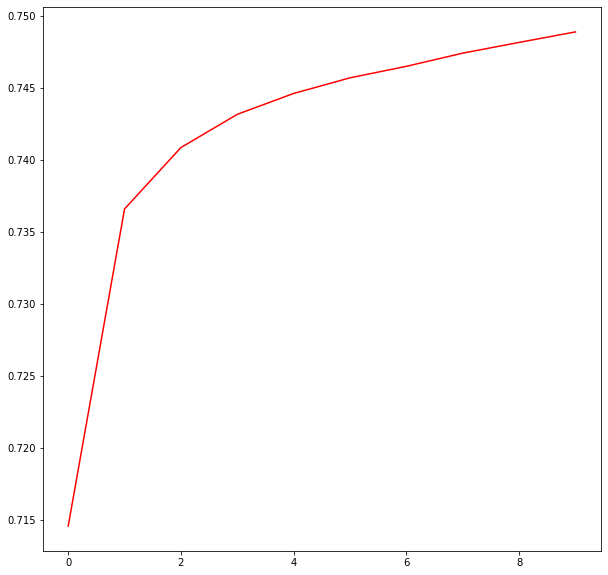

In [22]:
# Visualize Performance
f, axarr = plt.subplots(1, 1, figsize=(10, 10))
vfl_line, = axarr.plot(metrics["AUC"], c="red")
vfl_line.set_label("VFL")